# Vancomycin AUC Prediction Model Development and Validation


## Overview
This notebook develops machine learning models to predict vancomycin Area Under the Curve (AUC) concentrations.
The analysis includes:
- Binary classification (AUC > 600 mg·h/L)
- Regression models for exact AUC prediction
- Internal validation with time-based split
- SMOTE for handling class imbalance
- Comparison with PrecisePK software
- External validation on independent dataset

## 1. Environment Setup and Dependencies

In [1]:
!pip install catboost  # Only required in Google Colab


import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from collections import Counter
from google.colab import files
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

# Reproducibility
np.random.seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

# Data Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning Models – Classification
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning Models – Regression
# (Optional: Remove if not used)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    mean_squared_error, mean_absolute_error, r2_score
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


 ## 2. Data Loading and Initial Exploration

In [2]:
uploaded = files.upload()
for filename in uploaded.keys():
    df_full = pd.read_excel(filename)
    print(f"Full dataset loaded: {filename}")

Saving Vancomycin_auc_prediction_training.xlsx to Vancomycin_auc_prediction_training.xlsx
Full dataset loaded: Vancomycin_auc_prediction_training.xlsx


In [3]:
 df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Male                    553 non-null    int64  
 1   Initial VCM_daily_dose  553 non-null    int64  
 2   AUC                     553 non-null    float64
 3   Scr                     553 non-null    float64
 4   Cockcroft-Gault CrCl    553 non-null    float64
 5   MDRD                    553 non-null    float64
 6   Age                     553 non-null    int64  
 7   BW                      553 non-null    float64
 8   Height                  553 non-null    float64
 9   BMI                     553 non-null    float64
 10  NSAIDs                  553 non-null    int64  
 11  Vasopressors            553 non-null    int64  
 12  FLC                     553 non-null    int64  
 13  FQ                      553 non-null    int64  
 14  LAB                     553 non-null    in

In [4]:
df_full.isnull().sum()

,0
Male,0
Initial VCM_daily_dose,0
AUC,0
Scr,0
Cockcroft-Gault CrCl,0
MDRD,0
Age,0
BW,0
Height,0
BMI,0


In [5]:
df_full.head()

,Male,Initial VCM_daily_dose,AUC,Scr,Cockcroft-Gault CrCl,MDRD,Age,BW,Height,BMI,...,ICU,WBC,RBC,Hb,PLT,CRP,BUN,Albumin,TP,UA
0,0,2000,509.0,0.61,69.439891,96.686509,71,52.0,150.0,23.111111,...,0,5.5,3.46,11.7,167,3.62,11.0,3.7,6.2,2.1
1,1,2400,515.0,0.86,61.046512,86.232151,77,60.0,160.0,23.437500,...,0,3.9,3.49,9.5,159,89.05,12.0,3.4,6.5,3.3
2,1,1500,472.0,0.60,71.759259,130.303566,78,50.0,151.0,21.928863,...,0,9.4,3.84,11.0,255,8.00,14.0,3.3,7.8,4.4
3,1,1600,456.0,1.27,56.496063,58.246881,58,63.0,168.0,22.321429,...,0,7.3,3.75,11.1,223,24.45,16.9,4.2,6.7,5.0
4,1,1800,411.0,0.81,66.872428,92.898543,75,60.0,168.0,21.258503,...,0,0.4,2.89,9.2,65,91.59,12.8,2.8,5.4,4.4


## 3. Data Preprocessing and Feature Engineering

In [6]:
# Extract features (exclude AUC)
X_full = df_full.drop(columns=['AUC'])

# Define binary target: 1 if AUC > 600, else 0
y_full = (df_full['AUC'] > 600).astype(int)

# Check feature and label shape
print("Feature and label extraction completed.")
print(f"- X shape: {X_full.shape}")
print(f"- y (AUC > 600) class distribution:\n{y_full.value_counts()}")

Feature and label extraction completed.
- X shape: (553, 30)
- y (AUC > 600) class distribution:
AUC
0    458
1     95
Name: count, dtype: int64


In [7]:
# Utility function to print class distribution
def print_auc_distribution(data, label, by_label=True):
    total = len(data)

    if by_label:
        count = data.sum()
    else:
        count = (data['AUC'] > 600).sum()

    print(f"\n[{label}]")
    print(f"AUC > 600: {count} cases ({count / total * 100:.1f}%)")

print_auc_distribution(df_full, "Full Dataset", by_label=False)


[Full Dataset]
AUC > 600: 95 cases (17.2%)


In [8]:
# Time-based train/test split (80/20)
split_point = int(len(df_full) * 0.80)
train_df = df_full.iloc[:split_point]
test_df = df_full.iloc[split_point:]

# Print distribution for each split
print_auc_distribution(train_df, "Train Set (First 80%)", by_label=False)
print_auc_distribution(test_df, "Test Set (Last 20%)", by_label=False)


[Train Set (First 80%)]
AUC > 600: 77 cases (17.4%)

[Test Set (Last 20%)]
AUC > 600: 18 cases (16.2%)


## 4. Multicollinearity Analysis (VIF)


In [9]:
# Drop target column to isolate features
X_full = df_full.drop(columns=["AUC"])

# Select only numeric columns for VIF analysis
X_numeric = X_full.select_dtypes(include=[np.number])

# Apply standard scaling before VIF calculation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort by VIF in descending order
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

# Display result
print("VIF calculation completed. Features with high multicollinearity:")
display(vif_data)

VIF calculation completed. Features with high multicollinearity:


,Feature,VIF
0,BW,99.596445
1,BMI,63.300899
2,Height,33.985851
3,Cockcroft-Gault CrCl,18.895147
4,MDRD,11.348546
5,Hb,5.256463
6,RBC,5.217876
7,Age,3.958844
8,Scr,3.826527
9,BUN,2.490092


## 5. Feature Selection Based on VIF

In [10]:
# Drop selected variables based on multicollinearity or redundancy
X_reduced = X_numeric.drop(columns=[
    "BW", "Height", "RBC", "Cockcroft-Gault CrCl", "MDRD"
])

print(f"Final feature set shape after dropping 5 variables: {X_reduced.shape}")
display(X_reduced.head())

# Recalculate VIF after variable reduction
scaler = StandardScaler()
X_scaled_reduced = scaler.fit_transform(X_reduced)

vif_df = pd.DataFrame({
    "Feature": X_reduced.columns,
    "VIF": [variance_inflation_factor(X_scaled_reduced, i) for i in range(X_scaled_reduced.shape[1])]
})

Final feature set shape after dropping 5 variables: (553, 25)


,Male,Initial VCM_daily_dose,Scr,Age,BMI,NSAIDs,Vasopressors,FLC,FQ,LAB,...,Diuretics,ICU,WBC,Hb,PLT,CRP,BUN,Albumin,TP,UA
0,0,2000,0.61,71,23.111111,0,0,0,0,0,...,0,0,5.5,11.7,167,3.62,11.0,3.7,6.2,2.1
1,1,2400,0.86,77,23.437500,1,0,0,0,0,...,0,0,3.9,9.5,159,89.05,12.0,3.4,6.5,3.3
2,1,1500,0.60,78,21.928863,0,0,0,0,0,...,0,0,9.4,11.0,255,8.00,14.0,3.3,7.8,4.4
3,1,1600,1.27,58,22.321429,0,0,0,0,0,...,0,0,7.3,11.1,223,24.45,16.9,4.2,6.7,5.0
4,1,1800,0.81,75,21.258503,1,0,0,0,0,...,0,0,0.4,9.2,65,91.59,12.8,2.8,5.4,4.4


In [11]:
# Sort and display VIF results after dropping selected features
vif_df = vif_df.sort_values(by="VIF", ascending=False).reset_index(drop=True)

print("Recalculated VIF after dropping selected features:")
display(vif_df)

Recalculated VIF after dropping selected features:


,Feature,VIF
0,Scr,2.557828
1,BUN,2.443695
2,Albumin,1.952235
3,UA,1.667023
4,Hb,1.589602
5,Initial VCM_daily_dose,1.577863
6,ICU,1.395195
7,Age,1.387713
8,Fusosemide,1.350810
9,CRP,1.347012


## 6. Time-Based Train-Test Split


In [12]:
# Time-based split (80:20)
split_point = int(len(X_reduced) * 0.80)
X_train = X_reduced.iloc[:split_point]
X_val = X_reduced.iloc[split_point:]
y_train = y_full.iloc[:split_point]
y_val = y_full.iloc[split_point:]

# Wrap splits into dictionaries
splits_dict = {
    "time_80": (X_train, X_val)
}
label_dict = {
    "auc_600_time_80": (y_train, y_val)
}

# Standard scaling function
def scale_split_data(splits_dict):
    scaled_splits = {}
    for key, (X_tr, X_va) in splits_dict.items():
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_va_scaled = scaler.transform(X_va)
        scaled_splits[key] = (X_tr_scaled, X_va_scaled)
    return scaled_splits

scaled_results = scale_split_data(splits_dict)

# Check split shapes
print("Time-based split and scaling completed.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Time-based split and scaling completed.
X_train shape: (442, 25), y_train shape: (442,)
X_val shape: (111, 25), y_val shape: (111,)


## 7. Binary Classification Model Development

In [13]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Get predicted probabilities or decision scores
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_val)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min() + 1e-10)
    else:
        y_prob = None

    # Evaluation metrics
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_prob) if y_prob is not None else np.nan
    pr_auc = average_precision_score(y_val, y_prob) if y_prob is not None else np.nan

    return acc, cm, prec, rec, f1, roc_auc, pr_auc

In [14]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'VotingClassifier': VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
        ('rf', RandomForestClassifier(class_weight='balanced')),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ], voting='soft')
}

In [15]:
results = []

for split_key, (X_train_scaled, X_val_scaled) in scaled_results.items():
    y_train, y_val = label_dict[f"auc_600_{split_key}"]

    for model_name, model in models.items():
        acc, cm, prec, rec, f1, roc_auc, pr_auc = evaluate_model(
            model, X_train_scaled, y_train, X_val_scaled, y_val
        )
        # Specificity: TN / (TN + FP)
        specificity = cm[0][0] / (cm[0][0] + cm[0][1]) if (cm[0][0] + cm[0][1]) > 0 else 0
        # NPV: TN / (TN + FN)
        npv = cm[0][0] / (cm[0][0] + cm[1][0]) if (cm[0][0] + cm[1][0]) > 0 else 0

        results.append({
            "Model": model_name,
            "PR-AUC": pr_auc,
            "ROC-AUC": roc_auc,
            "F1 Score": f1,
            "Sensitivity": rec,
            "Specificity": specificity,
            "PPV": prec,
            "NPV": npv,
            "Accuracy": acc,
            "TP": cm[1][1],
            "FN": cm[1][0],
            "FP": cm[0][1],
            "TN": cm[0][0],
        })



In [16]:
column_order = [
    "Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity", "PPV", "NPV", "Accuracy",
    "TP", "FN", "FP", "TN"
]
results_df = pd.DataFrame(results)[column_order]

In [17]:
display(results_df)

,Model,PR-AUC,ROC-AUC,F1 Score,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
0,LogisticRegression,0.563995,0.823178,0.464286,0.722222,0.731183,0.342105,0.931507,0.729730,13,5,25,68
1,RidgeClassifier,0.585470,0.837515,0.517241,0.833333,0.731183,0.375000,0.957746,0.747748,15,3,25,68
2,KNN,0.274921,0.709976,0.206897,0.166667,0.913978,0.272727,0.850000,0.792793,3,15,8,85
3,SVM,0.383243,0.718638,0.355556,0.444444,0.795699,0.296296,0.880952,0.738739,8,10,19,74
4,RandomForest,0.355605,0.771505,0.000000,0.000000,1.000000,0.000000,0.837838,0.837838,0,18,0,93
5,GradientBoosting,0.500941,0.765830,0.333333,0.222222,0.978495,0.666667,0.866667,0.855856,4,14,2,91
6,XGBoost,0.314288,0.724612,0.285714,0.222222,0.935484,0.400000,0.861386,0.819820,4,14,6,87
7,CatBoost,0.445991,0.749701,0.105263,0.055556,1.000000,1.000000,0.845455,0.846847,1,17,0,93
8,ExtraTrees,0.365151,0.727897,0.000000,0.000000,1.000000,0.000000,0.837838,0.837838,0,18,0,93
9,VotingClassifier,0.476655,0.825568,0.240000,0.166667,0.956989,0.428571,0.855769,0.828829,3,15,4,89


In [18]:
results_df.to_excel("results_summary.xlsx", index=False)
files.download("results_summary.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 ## 8. Regression Model Development

In [19]:
# Evaluation function for ±20% and ±30% accuracy
def evaluate_regression_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ±20% Accuracy
    lower_20 = y_true * 0.80
    upper_20 = y_true * 1.20
    within_20 = ((y_pred >= lower_20) & (y_pred <= upper_20)).sum()
    acc_20 = within_20 / len(y_true)

    # ±30% Accuracy
    lower_30 = y_true * 0.70
    upper_30 = y_true * 1.30
    within_30 = ((y_pred >= lower_30) & (y_pred <= upper_30)).sum()
    acc_30 = within_30 / len(y_true)

    return acc_20, acc_30


In [20]:
reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42)
}

In [21]:
y_full = df_full["AUC"]

print(" y_full (AUC values) defined.")
print(f"- Total samples: {len(y_full)}")
print(f"- AUC sample preview:\n{y_full.head()}")

 y_full (AUC values) defined.
- Total samples: 553
- AUC sample preview:
0    509.0
1    515.0
2    472.0
3    456.0
4    411.0
Name: AUC, dtype: float64


In [22]:
# Split original AUC values as regression target
y_full_auc = df_full['AUC']
y_train_auc = y_full_auc.iloc[:split_point]
y_val_auc = y_full_auc.iloc[split_point:]

# Evaluate regression models
reg_results = []

for model_name, model in reg_models.items():
    model.fit(X_train, y_train_auc)
    y_pred = model.predict(X_val)

    # Evaluate accuracy within ±20% and ±30%
    acc_20, acc_30 = evaluate_regression_accuracy(y_val_auc, y_pred)

    # Calculate regression metrics
    rmse = np.sqrt(mean_squared_error(y_val_auc, y_pred))
    mae = mean_absolute_error(y_val_auc, y_pred)
    r2 = r2_score(y_val_auc, y_pred)

    reg_results.append({
        "Model": model_name,
        "±20% Accuracy": acc_20,
        "±30% Accuracy": acc_30,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# Convert to DataFrame and sort by ±20% accuracy
reg_results_df = pd.DataFrame(reg_results)
reg_results_df = reg_results_df.sort_values(by="±20% Accuracy", ascending=False).reset_index(drop=True)

# Print results
print("Regression model evaluation completed (±20%, ±30%, RMSE, MAE, R²):")
display(reg_results_df)

Regression model evaluation completed (±20%, ±30%, RMSE, MAE, R²):


,Model,±20% Accuracy,±30% Accuracy,RMSE,MAE,R²
0,LinearRegression,0.603604,0.747748,132.555664,95.221627,0.281176
1,Ridge,0.594595,0.747748,131.813188,94.849622,0.289206
2,CatBoost,0.576577,0.738739,146.304226,100.166802,0.124332
3,GradientBoosting,0.558559,0.711712,153.637922,105.435405,0.034343
4,ExtraTrees,0.558559,0.720721,144.770323,99.034029,0.142597
5,XGBoost,0.522523,0.684685,159.485408,113.273252,-0.040562
6,RandomForest,0.513514,0.711712,146.299529,104.157618,0.124388
7,KNN,0.504505,0.666667,169.986367,119.833946,-0.182100
8,SVR,0.468468,0.729730,158.351289,113.165600,-0.025815


## 9. SMOTE for Class Imbalance

In [23]:
# Define binary classification target for AUC > 600
y_smote_600 = (df_full["AUC"] > 600).astype(int)

print("Binary classification target created.")
print(f"AUC > 600: {y_smote_600.sum()} positive / {len(y_smote_600) - y_smote_600.sum()} negative")

# Initialize dictionary to store SMOTE-applied datasets with scaling
smote_results = {}
smote_scalers = {}

# Apply SMOTE to each split in splits_dict
for split_name, (X_train_df, X_val_df) in splits_dict.items():
    print(f"\n=== Processing {split_name} ===")

    y_train_600 = y_smote_600.loc[X_train_df.index]
    y_val_600 = y_smote_600.loc[X_val_df.index]

    print(f"Original class distribution - Train: {Counter(y_train_600)}")

    # Step 1: Apply SMOTE on original scale data
    sm = SMOTE(random_state=42)
    X_train_600_smote, y_train_600_smote = sm.fit_resample(X_train_df, y_train_600)

    print(f"After SMOTE class distribution: {Counter(y_train_600_smote)}")
    print(f"SMOTE samples added: {len(X_train_600_smote) - len(X_train_df)}")

    # Step 2: Apply scaling AFTER SMOTE
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_600_smote)  # Fit on SMOTE data
    X_val_scaled = scaler.transform(X_val_df)  # Transform validation data


    smote_results[split_name] = {
        "X_train": X_train_scaled,
        "y_train": y_train_600_smote,
        "X_val": X_val_scaled,
        "y_val": y_val_600
    }

    # Store scaler for later use (external validation)
    smote_scalers[split_name] = scaler

Binary classification target created.
AUC > 600: 95 positive / 458 negative

=== Processing time_80 ===
Original class distribution - Train: Counter({0: 365, 1: 77})
After SMOTE class distribution: Counter({0: 365, 1: 365})
SMOTE samples added: 288


## 10. Evaluate Models with SMOTE

In [24]:
smote_eval_results = []
ridge_model_smote = None
ridge_scaler_smote = None

for split_key, data in smote_results.items():
    X_train_smote_scaled = data["X_train"]
    y_train_smote = data["y_train"]
    X_val_scaled = data["X_val"]
    y_val = data["y_val"]

    for model_name, model in models.items():
        acc, cm, prec, rec, f1, roc_auc, pr_auc = evaluate_model(
            model, X_train_smote_scaled, y_train_smote, X_val_scaled, y_val
        )

        specificity = cm[0][0] / (cm[0][0] + cm[0][1]) if (cm[0][0] + cm[0][1]) > 0 else 0
        npv = cm[0][0] / (cm[0][0] + cm[1][0]) if (cm[0][0] + cm[1][0]) > 0 else 0

        # Save best ridge model and scaler for later use
        if model_name == "RidgeClassifier" and split_key == "time_80":
            ridge_model_smote = model
            ridge_scaler_smote = smote_scalers[split_key]

        smote_eval_results.append({
            "Split": split_key,
            "Target": "AUC > 600 (SMOTE)",
            "Model": model_name,
            "PR-AUC": pr_auc,
            "ROC-AUC": roc_auc,
            "F1 Score": f1,
            "Sensitivity": rec,
            "Specificity": specificity,
            "PPV": prec,
            "NPV": npv,
            "Accuracy": acc,
            "TP": cm[1][1],
            "FN": cm[1][0],
            "FP": cm[0][1],
            "TN": cm[0][0],
        })

smote_results_df = pd.DataFrame(smote_eval_results)

column_order = [
    "Model", "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity",
    "PPV", "NPV", "Accuracy", "TP", "FN", "FP", "TN"
]
smote_results_df = smote_results_df[column_order + [col for col in smote_results_df.columns if col not in column_order]]

smote_results_df = smote_results_df.sort_values(
    by=["Target", "Split", "Sensitivity"], ascending=[True, True, False]
).reset_index(drop=True)

print("\n=== SMOTE-based model evaluation completed ===")
print("All models trained on properly scaled SMOTE data")

final_smote_results_df = smote_results_df.drop(columns=["Split", "Target"])

final_smote_results_df.to_excel("SMOTE_Model_Performance.xlsx", index=False)

display(final_smote_results_df.head(10))


=== SMOTE-based model evaluation completed ===
All models trained on properly scaled SMOTE data


,Model,PR-AUC,ROC-AUC,F1 Score,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
0,LogisticRegression,0.431226,0.770609,0.489796,0.666667,0.795699,0.387097,0.925000,0.774775,12,6,19,74
1,RidgeClassifier,0.435904,0.771804,0.458333,0.611111,0.795699,0.366667,0.913580,0.765766,11,7,19,74
2,KNN,0.203660,0.625149,0.317460,0.555556,0.623656,0.222222,0.878788,0.612613,10,8,35,58
3,XGBoost,0.305464,0.695938,0.411765,0.388889,0.903226,0.437500,0.884211,0.819820,7,11,9,84
4,VotingClassifier,0.390247,0.765233,0.375000,0.333333,0.913978,0.428571,0.876289,0.819820,6,12,8,85
5,RandomForest,0.369794,0.723417,0.344828,0.277778,0.935484,0.454545,0.870000,0.828829,5,13,6,87
6,GradientBoosting,0.336500,0.721625,0.333333,0.277778,0.924731,0.416667,0.868687,0.819820,5,13,7,86
7,CatBoost,0.304635,0.684588,0.303030,0.277778,0.892473,0.333333,0.864583,0.792793,5,13,10,83
8,SVM,0.225364,0.631422,0.133333,0.111111,0.892473,0.166667,0.838384,0.765766,2,16,10,83
9,ExtraTrees,0.199396,0.589606,0.129032,0.111111,0.881720,0.153846,0.836735,0.756757,2,16,11,82


In [25]:
final_smote_results_df.to_excel("smote_results_summary.xlsx", index=False)

In [26]:
files.download("smote_results_summary.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Comparison with PrecisePK Software

In [27]:
# Load the file containing Precise PK predictions
uploaded = files.upload()
for filename in uploaded.keys():
    df_pk = pd.read_excel(filename)
    print(f"Loaded: {filename}")

Saving Vancomycin_auc_prediction_PrecisePk.xlsx to Vancomycin_auc_prediction_PrecisePk.xlsx
Loaded: Vancomycin_auc_prediction_PrecisePk.xlsx


In [28]:
def evaluate_binary(y_true, y_pred, y_score=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan
    pr_auc = average_precision_score(y_true, y_score) if y_score is not None else np.nan
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    return {
        "PR-AUC": pr_auc,
        "ROC-AUC": roc_auc,
        "F1 Score": f1,
        "Sensitivity": rec,
        "Specificity": specificity,
        "PPV": prec,
        "NPV": npv,
        "Accuracy": acc,
        "TP": tp,
        "FN": fn,
        "FP": fp,
        "TN": tn
    }


In [29]:
df_val = df_pk.iloc[split_point:].dropna(subset=["AUC", "Precise PK"])
y_true = (df_val["AUC"] > 600).astype(int)
y_pred_precisepk_auc = df_val["Precise PK"]
y_pred_precisepk = (y_pred_precisepk_auc > 600).astype(int)

print(f"dataset size: {len(df_val)}")
print(f"AUC > 600: {y_true.sum()}/{len(y_true)} ({y_true.mean():.1%})")
print(f"PrecisePK prediction AUC > 600: {y_pred_precisepk.sum()}/{len(y_pred_precisepk)} ({y_pred_precisepk.mean():.1%})")

results_pk = evaluate_binary(y_true, y_pred_precisepk, y_pred_precisepk_auc)

dataset size: 111
AUC > 600: 18/111 (16.2%)
PrecisePK prediction AUC > 600: 42/111 (37.8%)


In [30]:
# No SMOTE best model
best_nosmote = results_df.sort_values(by="Sensitivity", ascending=False).iloc[0]
print(f"No SMOTE best model: {best_nosmote['Model']} (Sensitivity: {best_nosmote['Sensitivity']:.4f})")

# SMOTE best model
best_smote = smote_results_df.sort_values(by="Sensitivity", ascending=False).iloc[0]
print(f"SMOTE best model: {best_smote['Model']} (Sensitivity: {best_smote['Sensitivity']:.4f})")

results_nosmote_best = best_nosmote.drop(labels=["Model"]).to_dict()
results_smote_best = best_smote.drop(labels=["Model"]).to_dict()

No SMOTE best model: RidgeClassifier (Sensitivity: 0.8333)
SMOTE best model: LogisticRegression (Sensitivity: 0.6667)


In [31]:
compare_columns = [
    "PR-AUC", "ROC-AUC", "F1 Score", "Sensitivity", "Specificity",
    "PPV", "NPV", "Accuracy", "TP", "FN", "FP", "TN"
]

pk_row = {k: results_pk.get(k, None) for k in compare_columns}

nosmote_row = {k: results_nosmote_best.get(k, None) for k in compare_columns}

smote_row = {k: results_smote_best.get(k, None) for k in compare_columns}

compare_df = pd.DataFrame(
    [pk_row, nosmote_row, smote_row],
    index=[
        "Precise PK",
        f"No SMOTE best: {best_nosmote['Model']}",
        f"SMOTE best: {best_smote['Model']}"
    ]
).round(4)

print("\n=== Final performance comparison ===")
display(compare_df)



=== Final performance comparison ===


,PR-AUC,ROC-AUC,F1 Score,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
Precise PK,0.4520,0.7772,0.4000,0.6667,0.6774,0.2857,0.9130,0.6757,12,6,30,63
No SMOTE best: RidgeClassifier,0.5855,0.8375,0.5172,0.8333,0.7312,0.3750,0.9577,0.7477,15,3,25,68
SMOTE best: LogisticRegression,0.4312,0.7706,0.4898,0.6667,0.7957,0.3871,0.9250,0.7748,12,6,19,74


## 12. External Validation

In [32]:
# Upload and load external validation dataset
uploaded = files.upload()
for filename in uploaded.keys():
    df_external = pd.read_excel(filename)
    print(f"Loaded external validation set: {filename}")

Saving Vancomycin_auc_prediction_external.xlsx to Vancomycin_auc_prediction_external.xlsx
Loaded external validation set: Vancomycin_auc_prediction_external.xlsx


In [33]:
print(f"External validation dataset shape: {df_external.shape}")
print("Columns:", df_external.columns.tolist())

External validation dataset shape: (35, 31)
Columns: ['Male', 'Initial VCM_daily_dose', 'AUC', 'Scr', 'Cockcroft-Gault CrCl', 'MDRD', 'Age', 'BW', 'Height', 'BMI', 'NSAIDs', 'Vasopressors', 'FLC', 'FQ', 'LAB', 'AG', 'TZP', 'ARB', 'ACEi', 'Fusosemide', 'Diuretics', 'ICU', 'WBC', 'RBC', 'Hb', 'PLT', 'CRP', 'BUN', 'Albumin', 'TP', 'UA']


In [34]:
# 1. Train RidgeClassifier (No SMOTE) with existing scaler
ridge_model = models["RidgeClassifier"]
ridge_model.fit(X_train, y_train)
joblib.dump(ridge_model, "ridge_model_no_smote.pkl")

# 2. Train LogisticRegression (SMOTE) using existing SMOTE results
logreg_model_smote = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_model_smote.fit(smote_results["time_80"]["X_train"], smote_results["time_80"]["y_train"])
joblib.dump(logreg_model_smote, "logreg_model_smote.pkl")

# 3. Save the existing scaler
joblib.dump(scaler, "scaler.pkl")

# Load models and scaler
ridge_model_no_smote = joblib.load("ridge_model_no_smote.pkl")
logreg_model_smote = joblib.load("logreg_model_smote.pkl")
scaler = joblib.load("scaler.pkl")

# Prepare external validation data
X_external = df_external[X_reduced.columns]
X_external_scaled = scaler.transform(X_external)
y_external_true = (df_external["AUC"] > 600).astype(int)

print(f"External AUC > 600: {y_external_true.sum()}/{len(y_external_true)} ({y_external_true.mean():.1%})")

# Predict with RidgeClassifier (No SMOTE)
y_pred_ridge = ridge_model_no_smote.predict(X_external_scaled)
y_score_ridge = ridge_model_no_smote.decision_function(X_external_scaled)
results_ridge = evaluate_binary(y_external_true, y_pred_ridge, y_score_ridge)

# Predict with LogisticRegression (SMOTE)
y_pred_logreg = logreg_model_smote.predict(X_external_scaled)
y_score_logreg = logreg_model_smote.decision_function(X_external_scaled)
results_logreg = evaluate_binary(y_external_true, y_pred_logreg, y_score_logreg)

# Combine results into comparison table
external_compare_df = pd.DataFrame([
    results_ridge,
    results_logreg
], index=[
    "External - RidgeClassifier (No SMOTE)",
    "External - LogisticRegression (SMOTE)"
]).round(4)

print("=== External Validation Results ===")
display(external_compare_df)

External AUC > 600: 7/35 (20.0%)
=== External Validation Results ===


,PR-AUC,ROC-AUC,F1 Score,Sensitivity,Specificity,PPV,NPV,Accuracy,TP,FN,FP,TN
External - RidgeClassifier (No SMOTE),0.2292,0.5255,0.3871,0.8571,0.3571,0.2500,0.9091,0.4571,6,1,18,10
External - LogisticRegression (SMOTE),0.3789,0.7194,0.4545,0.7143,0.6429,0.3333,0.9000,0.6571,5,2,10,18


## 13. Result summary

#### 1. Internal Validation Performance

**(a) Binary Classification – No SMOTE**

| Model              | PR-AUC   | ROC-AUC  | F1 Score | Sensitivity | Specificity | PPV      | NPV      | Accuracy | TP | FN | FP | TN |
|--------------------|----------|----------|----------|-------------|-------------|----------|----------|----------|----|----|----|----|
| LogisticRegression | 0.5640   | 0.8232   | 0.4643   | 0.7222      | 0.7312      | 0.3421   | 0.9315   | 0.7297   | 13 | 5  | 25 | 68 |
| RidgeClassifier    | 0.5855   | 0.8375   | 0.5172   | 0.8333      | 0.7312      | 0.3750   | 0.9577   | 0.7477   | 15 | 3  | 25 | 68 |
| KNN                | 0.2749   | 0.7100   | 0.2069   | 0.1667      | 0.9140      | 0.2727   | 0.8500   | 0.7928   | 3  | 15 | 8  | 85 |
| SVM                | 0.3832   | 0.7186   | 0.3556   | 0.4444      | 0.7957      | 0.2963   | 0.8810   | 0.7387   | 8  | 10 | 19 | 74 |
| RandomForest       | 0.3556   | 0.7715   | 0.0000   | 0.0000      | 1.0000      | 0.0000   | 0.8378   | 0.8378   | 0  | 18 | 0  | 93 |
| GradientBoosting   | 0.5009   | 0.7658   | 0.3333   | 0.2222      | 0.9785      | 0.6667   | 0.8667   | 0.8559   | 4  | 14 | 2  | 91 |
| XGBoost            | 0.3143   | 0.7246   | 0.2857   | 0.2222      | 0.9355      | 0.4000   | 0.8614   | 0.8198   | 4  | 14 | 6  | 87 |
| CatBoost           | 0.4460   | 0.7497   | 0.1053   | 0.0556      | 1.0000      | 1.0000   | 0.8455   | 0.8468   | 1  | 17 | 0  | 93 |
| ExtraTrees         | 0.3652   | 0.7279   | 0.0000   | 0.0000      | 1.0000      | 0.0000   | 0.8378   | 0.8378   | 0  | 18 | 0  | 93 |
| VotingClassifier   | 0.4767   | 0.8256   | 0.2400   | 0.1667      | 0.9570      | 0.4286   | 0.8558   | 0.8288   | 3  | 15 | 4  | 89 |

**(b) Regression Models**

| Model            | ±20% Accuracy | ±30% Accuracy | RMSE    | MAE     | R²      |
|------------------|----------------|----------------|---------|---------|---------|
| LinearRegression | 0.6036         | 0.7477         | 132.56  | 95.22   | 0.2812  |
| Ridge            | 0.5946         | 0.7477         | 131.81  | 94.85   | 0.2892  |
| CatBoost         | 0.5766         | 0.7387         | 146.30  | 100.17  | 0.1243  |
| GradientBoosting | 0.5586         | 0.7117         | 153.64  | 105.44  | 0.0343  |
| ExtraTrees       | 0.5586         | 0.7207         | 144.77  | 99.03   | 0.1426  |
| XGBoost          | 0.5225         | 0.6847         | 159.49  | 113.27  | -0.0406 |
| RandomForest     | 0.5135         | 0.7117         | 146.30  | 104.16  | 0.1244  |
| KNN              | 0.5045         | 0.6667         | 169.99  | 119.83  | -0.1821 |
| SVR              | 0.4685         | 0.7297         | 158.35  | 113.17  | -0.0258 |

**(c) Binary Classification – SMOTE Applied**

| Model              | PR-AUC   | ROC-AUC  | F1 Score | Sensitivity | Specificity | PPV      | NPV      | Accuracy | TP | FN | FP | TN |
|--------------------|----------|----------|----------|-------------|-------------|----------|----------|----------|----|----|----|----|
| LogisticRegression | 0.4312   | 0.7706   | 0.4898   | 0.6667      | 0.7957      | 0.3871   | 0.9250   | 0.7748   | 12 | 6  | 19 | 74 |
| RidgeClassifier    | 0.4359   | 0.7718   | 0.4583   | 0.6111      | 0.7957      | 0.3667   | 0.9136   | 0.7658   | 11 | 7  | 19 | 74 |
| KNN                | 0.2037   | 0.6251   | 0.3175   | 0.5556      | 0.6237      | 0.2222   | 0.8788   | 0.6126   | 10 | 8  | 35 | 58 |
| SVM                | 0.2254   | 0.6314   | 0.1333   | 0.1111      | 0.8925      | 0.1667   | 0.8384   | 0.7658   | 2  | 16 | 10 | 83 |
| RandomForest       | 0.3698   | 0.7234   | 0.3448   | 0.2778      | 0.9355      | 0.4545   | 0.8700   | 0.8288   | 5  | 13 | 6  | 87 |
| GradientBoosting   | 0.3365   | 0.7216   | 0.3333   | 0.2778      | 0.9247      | 0.4167   | 0.8687   | 0.8198   | 5  | 13 | 7  | 86 |
| XGBoost            | 0.3055   | 0.6959   | 0.4118   | 0.3889      | 0.9032      | 0.4375   | 0.8842   | 0.8198   | 7  | 11 | 9  | 84 |
| CatBoost           | 0.3046   | 0.6846   | 0.3030   | 0.2778      | 0.8925      | 0.3333   | 0.8646   | 0.7928   | 5  | 13 | 10 | 83 |
| ExtraTrees         | 0.1994   | 0.5896   | 0.1290   | 0.1111      | 0.8817      | 0.1538   | 0.8367   | 0.7568   | 2  | 16 | 11 | 82 |
| VotingClassifier   | 0.3912   | 0.7766   | 0.3750   | 0.3333      | 0.9140      | 0.4286   | 0.8763   | 0.8198   | 6  | 12 | 8  | 85 |



---

#### 2. Comparison with Precise PK Software

|       Model               | PR-AUC  | ROC-AUC | F1 Score | Sensitivity | Specificity | PPV    | NPV    | Accuracy | TP | FN | FP | TN |
|----------------------|---------|---------|----------|-------------|-------------|--------|--------|----------|----|----|----|----|
| Precise PK           | 0.4520  | 0.7772  | 0.4000   | 0.6667      | 0.6774      | 0.2857 | 0.9130 | 0.6757   | 12 | 6  | 30 | 63 |
| No SMOTE best: RidgeClassifier | 0.5855  | 0.8375  | 0.5172   | 0.8333      | 0.7312      | 0.3750 | 0.9577 | 0.7477   | 15 | 3  | 25 | 68 |
| SMOTE best: LogisticRegression | 0.4312  | 0.7706  | 0.4898   | 0.6667      | 0.7957      | 0.3871 | 0.9250 | 0.7748   | 12 | 6  | 19 | 74 |



---

#### 3. External Validation Performance

|                                 | PR-AUC  | ROC-AUC | F1 Score | Sensitivity | Specificity | PPV    | NPV    | Accuracy | TP | FN | FP | TN |
|---------------------------------|---------|---------|----------|-------------|-------------|--------|--------|----------|----|----|----|----|
| External - RidgeClassifier (No SMOTE)  | 0.2292  | 0.5255  | 0.3871   | 0.8571      | 0.3571      | 0.2500 | 0.9091 | 0.4571   | 6  | 1  | 18 | 10 |
| External - LogisticRegression (SMOTE)  | 0.3789  | 0.7194  | 0.4545   | 0.7143      | 0.6429      | 0.3333 | 0.9000 | 0.6571   | 5  | 2  | 10 | 18 |



---

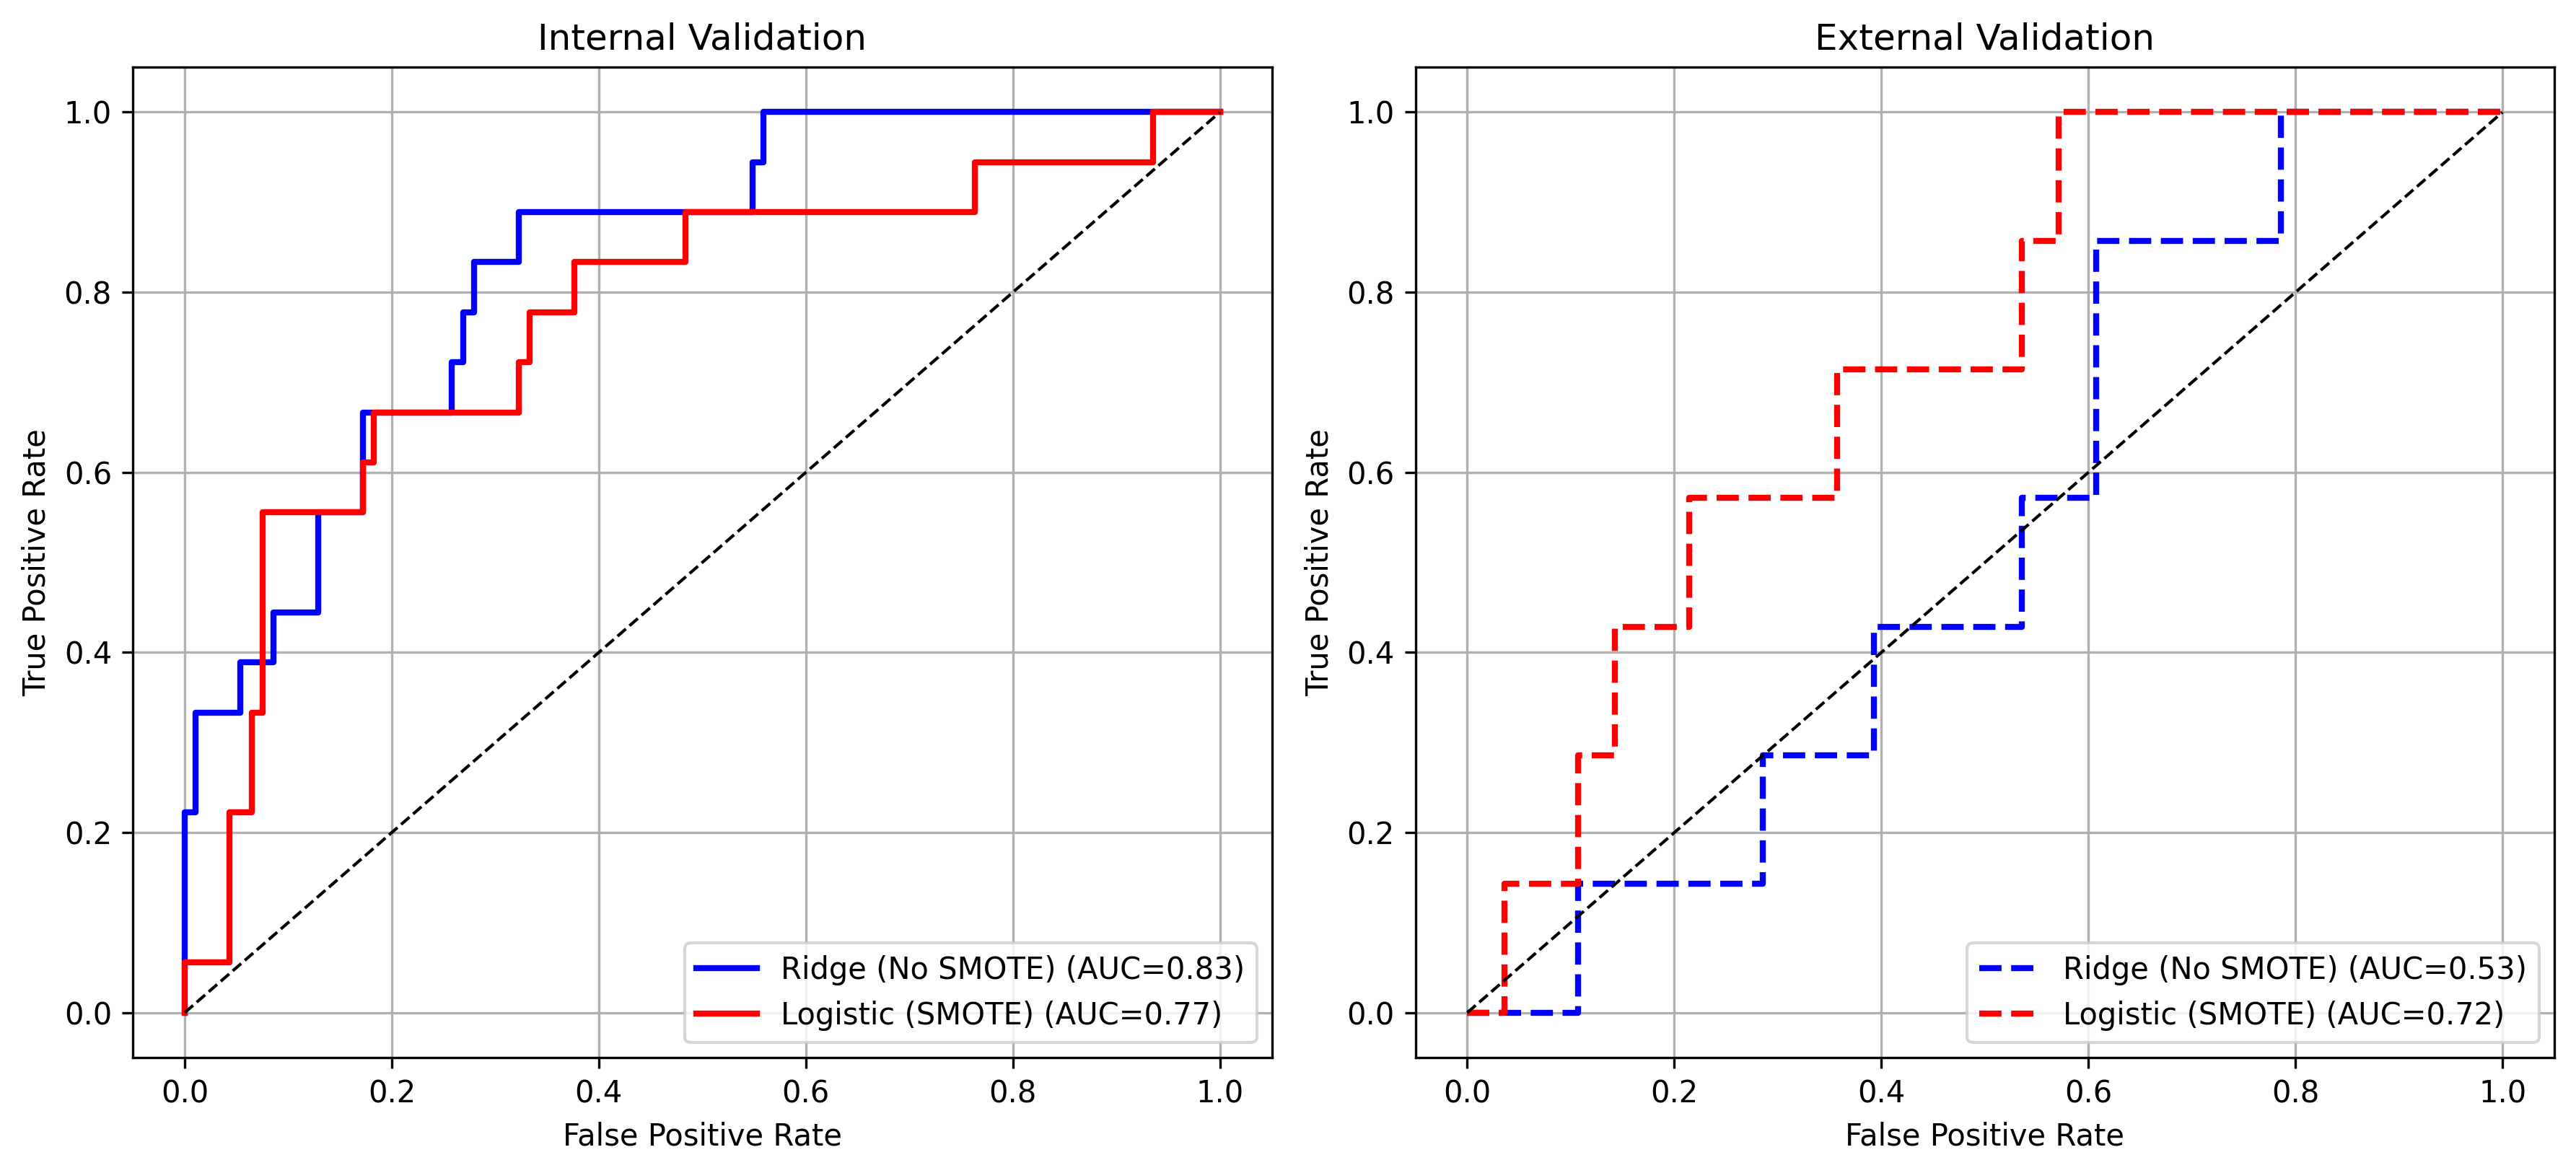

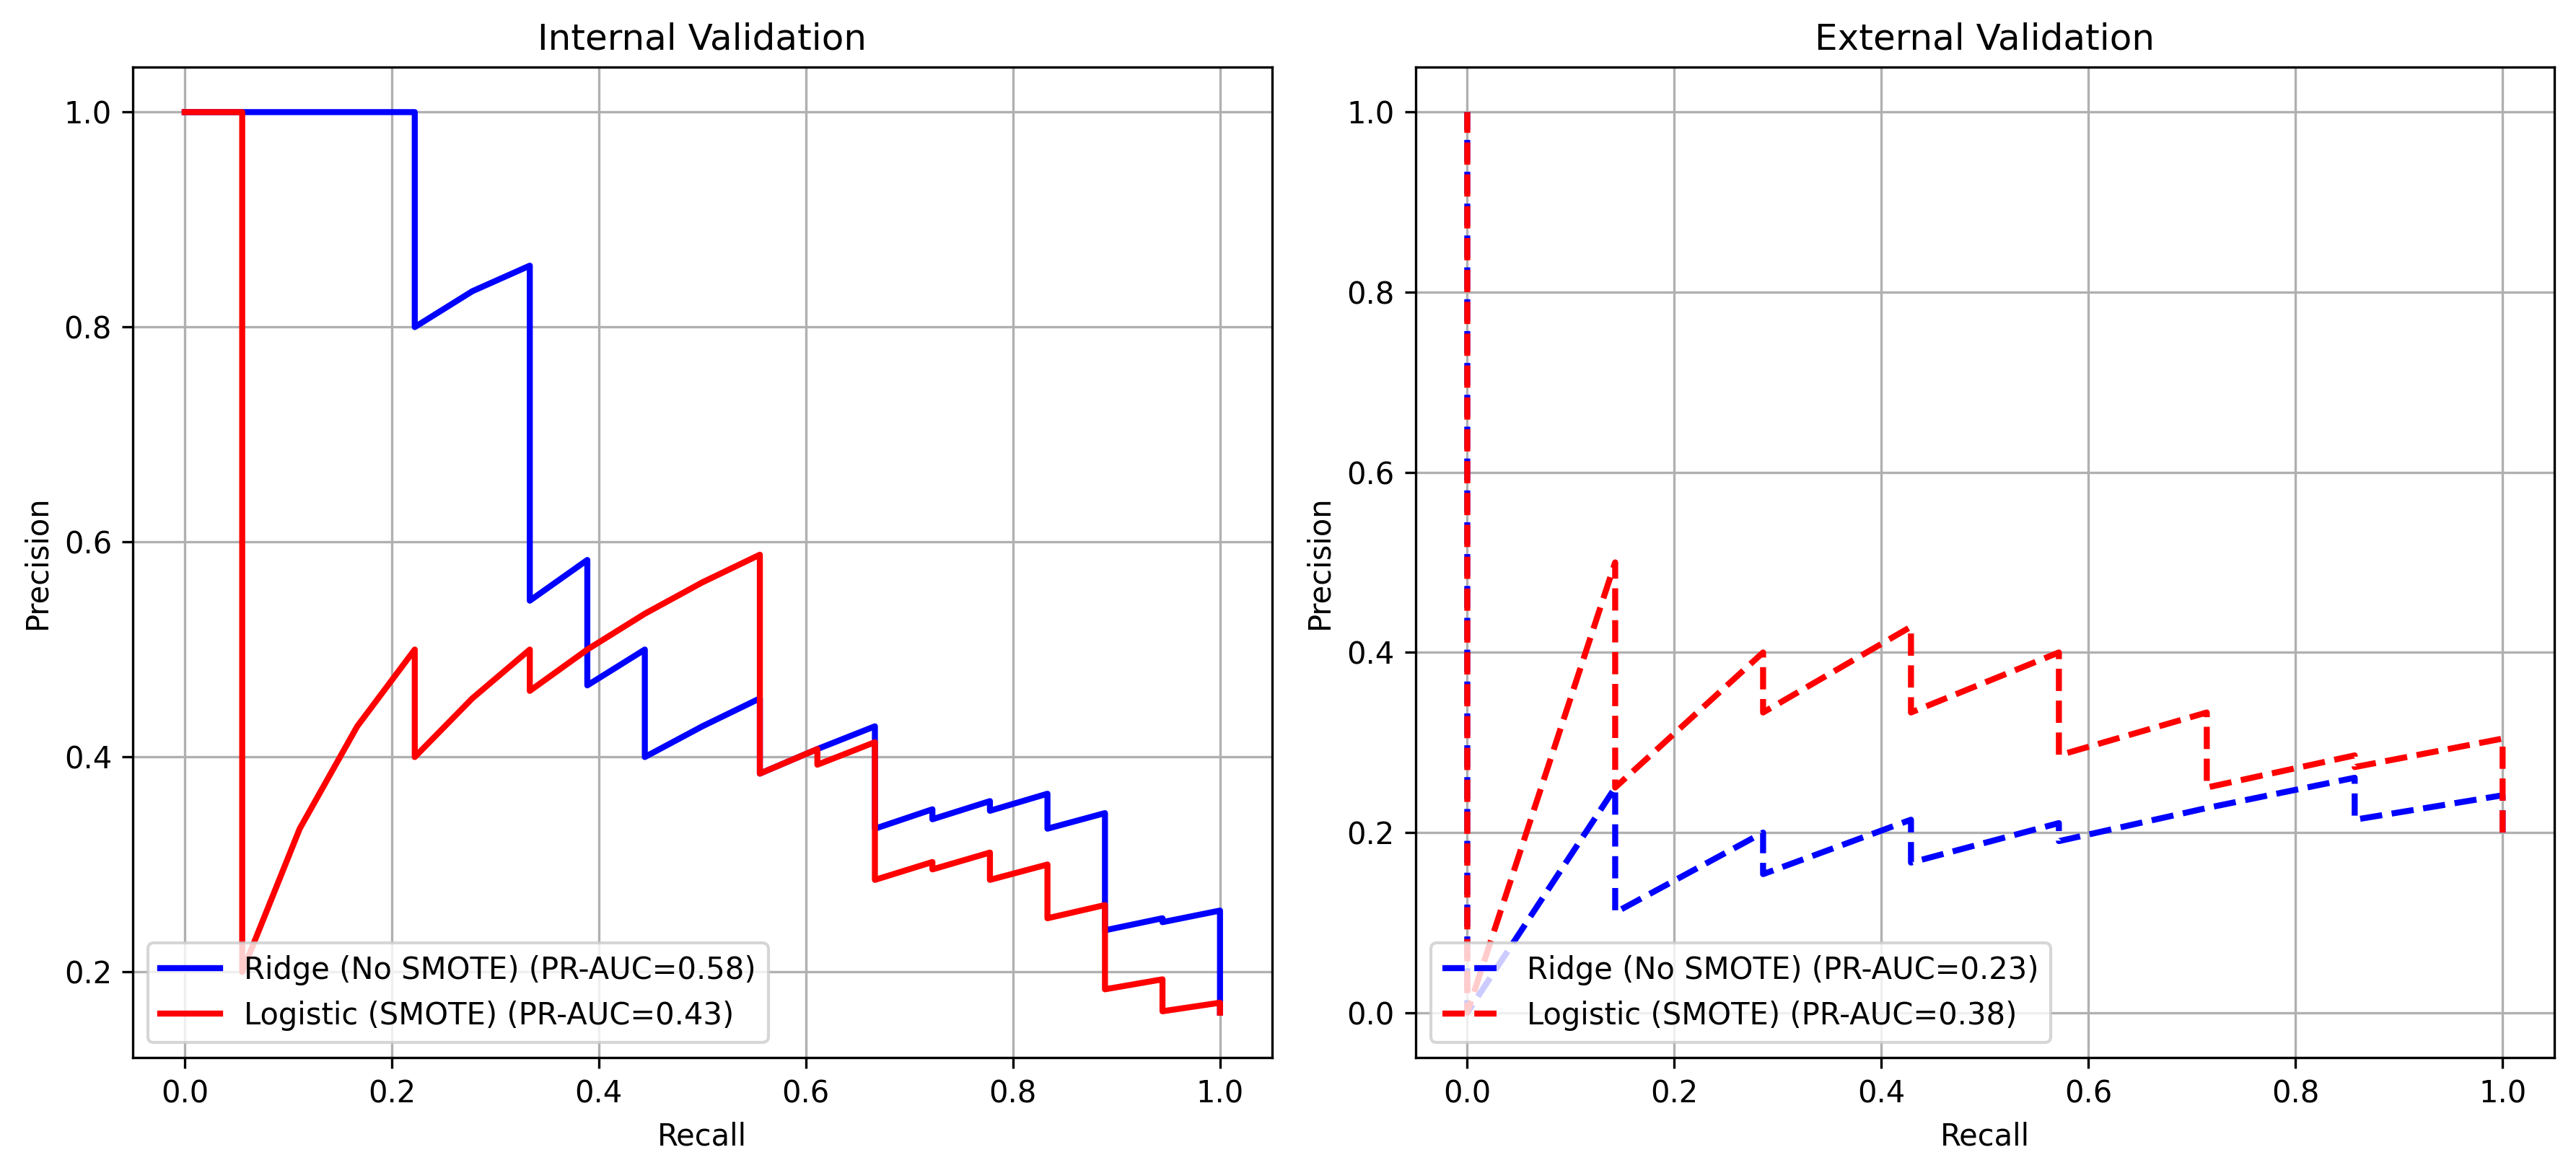

In [35]:
# 1. Internal/External Validation Set
# RidgeClassifier (No SMOTE)
# - Internal
y_score_ridge_int = ridge_model_no_smote.decision_function(X_val)
fpr_ridge_int, tpr_ridge_int, _ = roc_curve(y_val, y_score_ridge_int)
auc_ridge_int = auc(fpr_ridge_int, tpr_ridge_int)
precision_ridge_int, recall_ridge_int, _ = precision_recall_curve(y_val, y_score_ridge_int)
pr_auc_ridge_int = average_precision_score(y_val, y_score_ridge_int)

# - External
y_score_ridge_ext = ridge_model_no_smote.decision_function(X_external_scaled)
fpr_ridge_ext, tpr_ridge_ext, _ = roc_curve(y_external_true, y_score_ridge_ext)
auc_ridge_ext = auc(fpr_ridge_ext, tpr_ridge_ext)
precision_ridge_ext, recall_ridge_ext, _ = precision_recall_curve(y_external_true, y_score_ridge_ext)
pr_auc_ridge_ext = average_precision_score(y_external_true, y_score_ridge_ext)

# LogisticRegression (SMOTE)
# - Internal (반드시 SMOTE split의 X_val, y_val 써야 함)
X_val_smote = smote_results["time_80"]["X_val"]
y_val_smote = smote_results["time_80"]["y_val"]
y_score_logreg_int = logreg_model_smote.decision_function(X_val_smote)
fpr_logreg_int, tpr_logreg_int, _ = roc_curve(y_val_smote, y_score_logreg_int)
auc_logreg_int = auc(fpr_logreg_int, tpr_logreg_int)
precision_logreg_int, recall_logreg_int, _ = precision_recall_curve(y_val_smote, y_score_logreg_int)
pr_auc_logreg_int = average_precision_score(y_val_smote, y_score_logreg_int)

# - External
y_score_logreg_ext = logreg_model_smote.decision_function(X_external_scaled)
fpr_logreg_ext, tpr_logreg_ext, _ = roc_curve(y_external_true, y_score_logreg_ext)
auc_logreg_ext = auc(fpr_logreg_ext, tpr_logreg_ext)
precision_logreg_ext, recall_logreg_ext, _ = precision_recall_curve(y_external_true, y_score_logreg_ext)
pr_auc_logreg_ext = average_precision_score(y_external_true, y_score_logreg_ext)

# 2. Figure: Internal & External ROC curve (2 패널)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# ROC Internal
axes[0].plot(fpr_ridge_int, tpr_ridge_int, color='blue', lw=2, label=f'Ridge (No SMOTE) (AUC={auc_ridge_int:.2f})')
axes[0].plot(fpr_logreg_int, tpr_logreg_int, color='red', lw=2, label=f'Logistic (SMOTE) (AUC={auc_logreg_int:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Internal Validation')
axes[0].legend(loc='lower right')
axes[0].grid(True)

# ROC External
axes[1].plot(fpr_ridge_ext, tpr_ridge_ext, color='blue', lw=2, linestyle='--', label=f'Ridge (No SMOTE) (AUC={auc_ridge_ext:.2f})')
axes[1].plot(fpr_logreg_ext, tpr_logreg_ext, color='red', lw=2, linestyle='--', label=f'Logistic (SMOTE) (AUC={auc_logreg_ext:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('External Validation')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figure2_roc.png', dpi=300)
plt.show()

# 3. Figure: Internal & External PR curve (2 패널)
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# PR Internal
axes[0].plot(recall_ridge_int, precision_ridge_int, color='blue', lw=2, label=f'Ridge (No SMOTE) (PR-AUC={pr_auc_ridge_int:.2f})')
axes[0].plot(recall_logreg_int, precision_logreg_int, color='red', lw=2, label=f'Logistic (SMOTE) (PR-AUC={pr_auc_logreg_int:.2f})')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Internal Validation')
axes[0].legend(loc='lower left')
axes[0].grid(True)

# PR External
axes[1].plot(recall_ridge_ext, precision_ridge_ext, color='blue', lw=2, linestyle='--', label=f'Ridge (No SMOTE) (PR-AUC={pr_auc_ridge_ext:.2f})')
axes[1].plot(recall_logreg_ext, precision_logreg_ext, color='red', lw=2, linestyle='--', label=f'Logistic (SMOTE) (PR-AUC={pr_auc_logreg_ext:.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('External Validation')
axes[1].legend(loc='lower left')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('figure3_pr.png', dpi=300)
plt.show()


In [36]:
files.download('figure2_roc.png')
files.download('figure3_pr.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

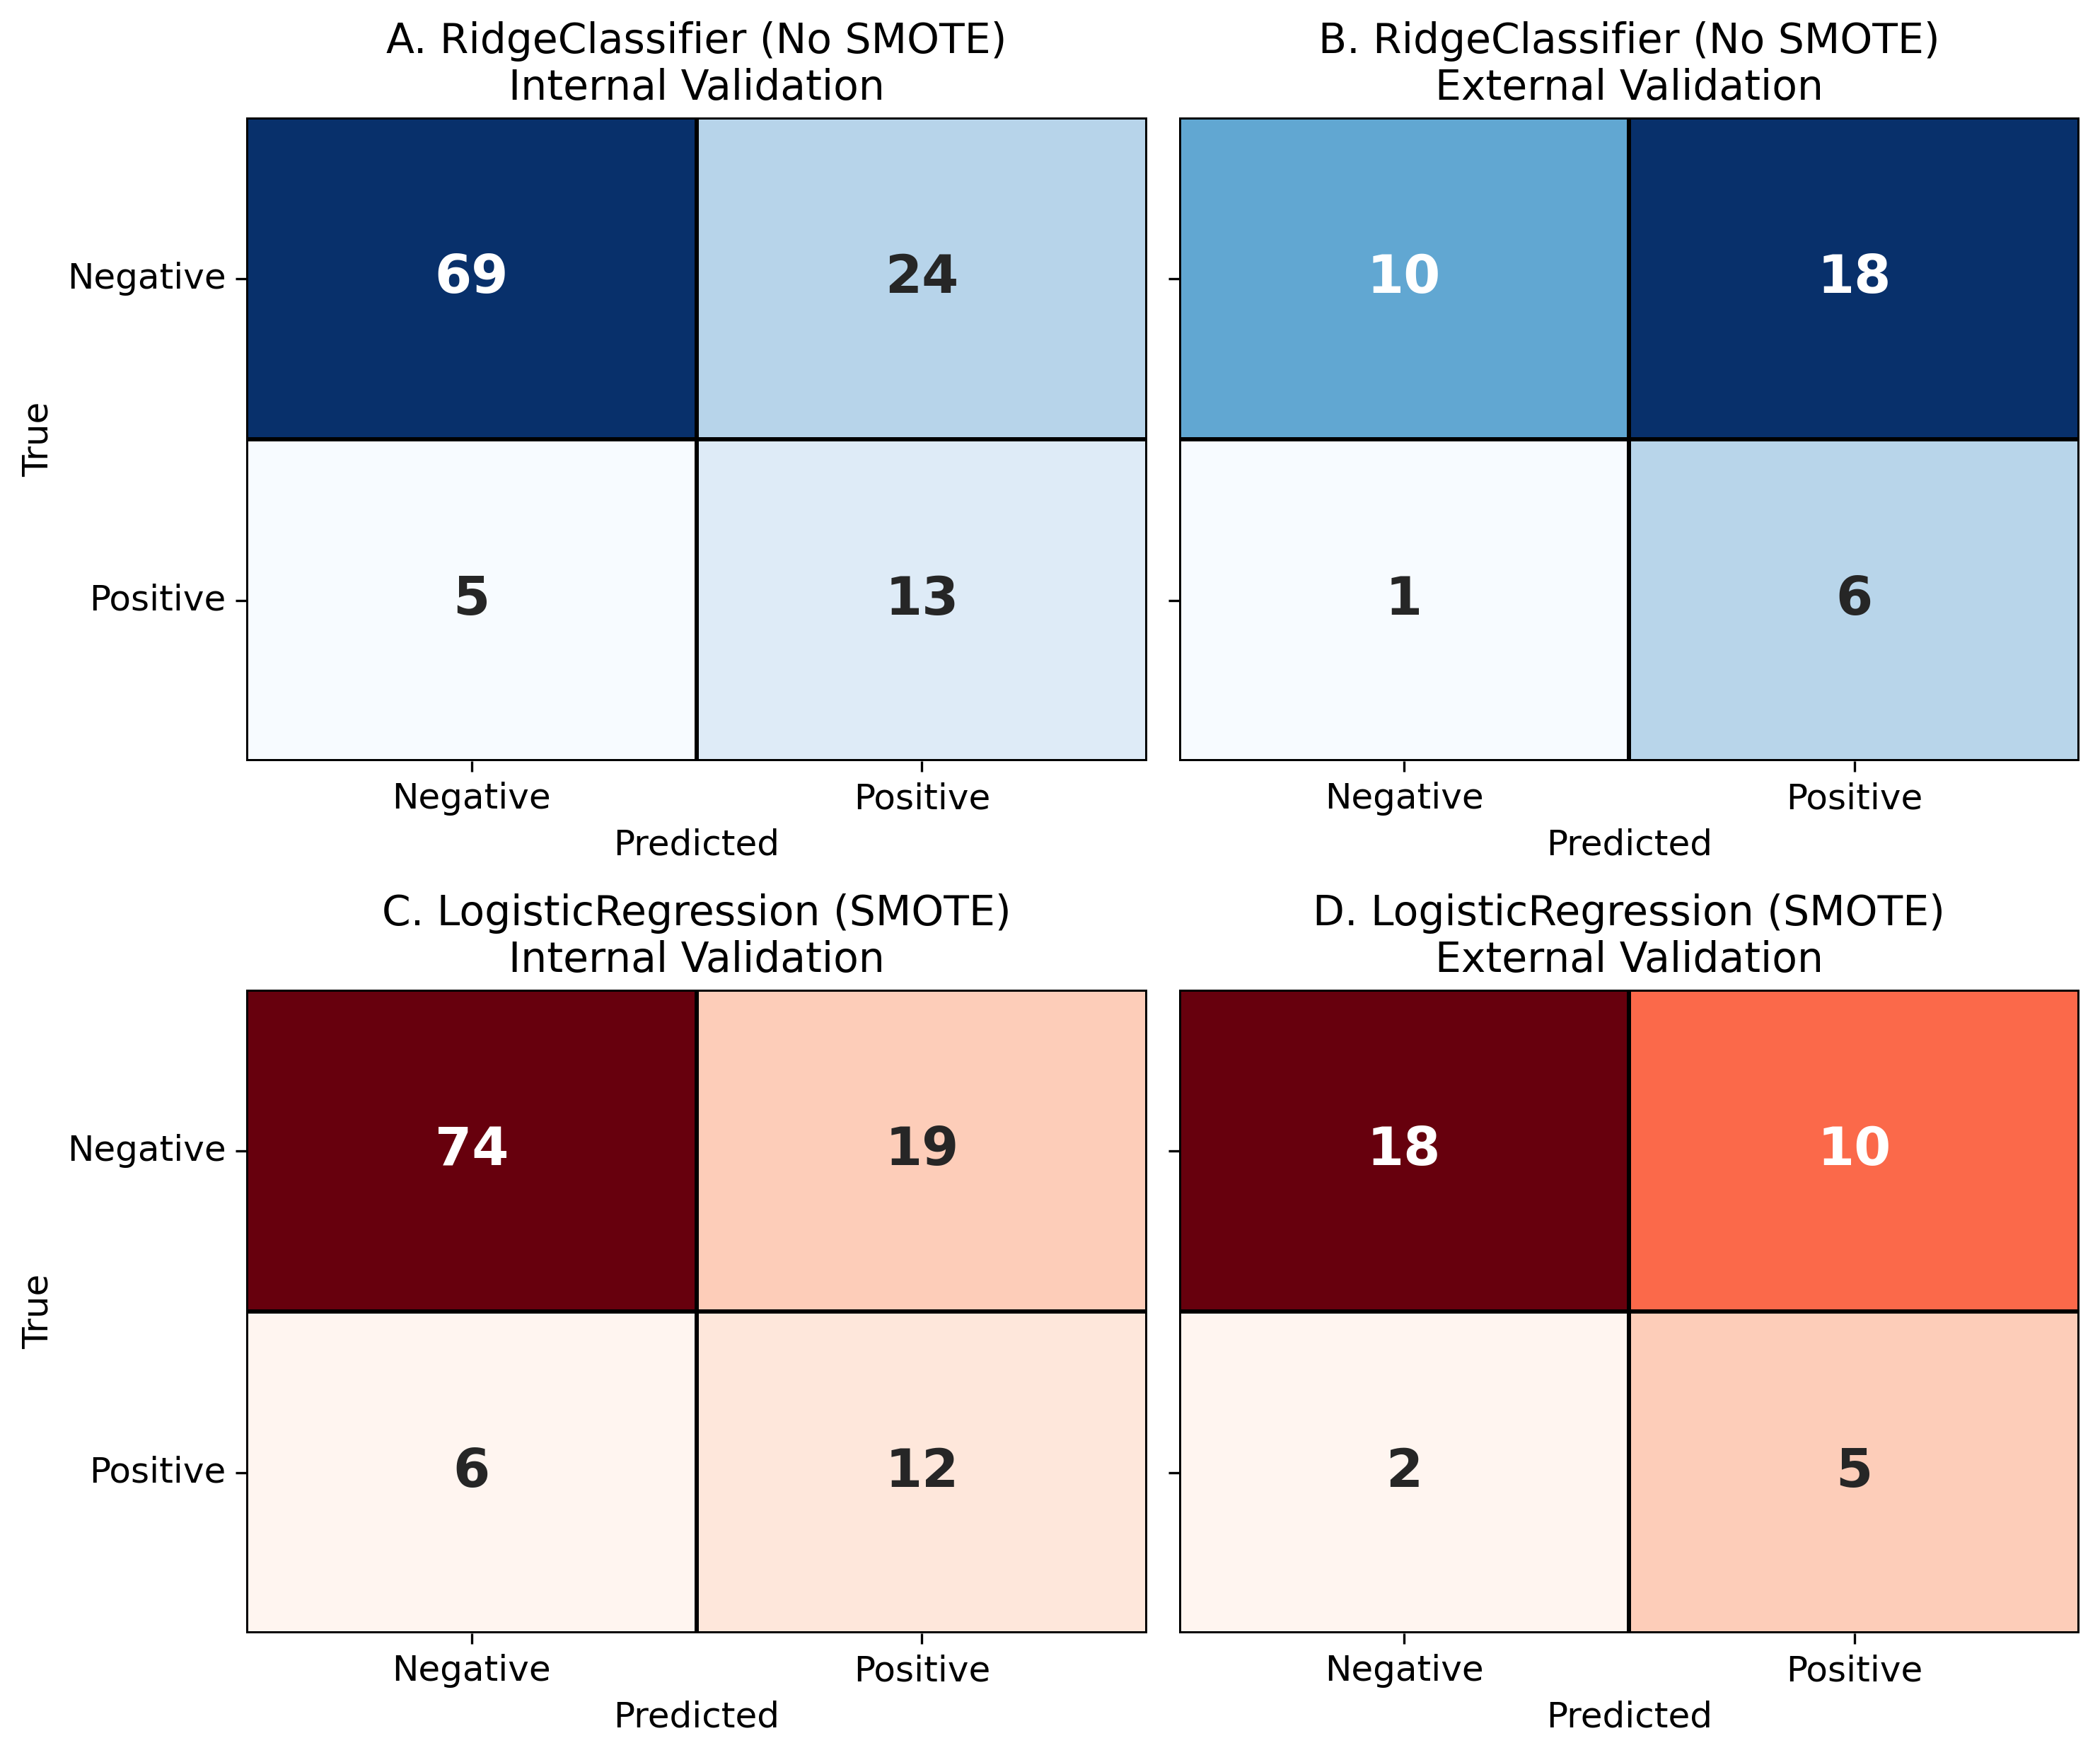

In [37]:
# --- 1. Prepare Data (각 모델 예측 결과) ---

# (A) Internal - Ridge (No SMOTE)
y_pred_ridge_int = ridge_model_no_smote.predict(X_val)
cm_ridge_int = confusion_matrix(y_val, y_pred_ridge_int)

# (B) External - Ridge (No SMOTE)
y_pred_ridge_ext = ridge_model_no_smote.predict(X_external_scaled)
cm_ridge_ext = confusion_matrix(y_external_true, y_pred_ridge_ext)

# (C) Internal - LogisticRegression (SMOTE)
X_val_smote = smote_results["time_80"]["X_val"]
y_val_smote = smote_results["time_80"]["y_val"]
y_pred_logreg_int = logreg_model_smote.predict(X_val_smote)
cm_logreg_int = confusion_matrix(y_val_smote, y_pred_logreg_int)

# (D) External - LogisticRegression (SMOTE)
y_pred_logreg_ext = logreg_model_smote.predict(X_external_scaled)
cm_logreg_ext = confusion_matrix(y_external_true, y_pred_logreg_ext)

# --- 2. Draw 2x2 confusion matrix figure ---

fig, axes = plt.subplots(2, 2, figsize=(10, 9), dpi=300)
cmap = sns.color_palette("Blues", as_cmap=True)

# (A) Internal Ridge (No SMOTE)
sns.heatmap(cm_ridge_int, annot=True, fmt='d', cmap=cmap, cbar=False,
            annot_kws={"size": 18, "weight": "bold"}, ax=axes[0, 0], linewidths=1, linecolor="black")
axes[0, 0].set_title("A. RidgeClassifier (No SMOTE)\nInternal Validation", fontsize=14)
axes[0, 0].set_xlabel("Predicted", fontsize=12)
axes[0, 0].set_ylabel("True", fontsize=12)
axes[0, 0].set_xticklabels(['Negative', 'Positive'], fontsize=12)
axes[0, 0].set_yticklabels(['Negative', 'Positive'], fontsize=12, rotation=0)

# (B) External Ridge (No SMOTE)
sns.heatmap(cm_ridge_ext, annot=True, fmt='d', cmap=cmap, cbar=False,
            annot_kws={"size": 18, "weight": "bold"}, ax=axes[0, 1], linewidths=1, linecolor="black")
axes[0, 1].set_title("B. RidgeClassifier (No SMOTE)\nExternal Validation", fontsize=14)
axes[0, 1].set_xlabel("Predicted", fontsize=12)
axes[0, 1].set_ylabel("")
axes[0, 1].set_xticklabels(['Negative', 'Positive'], fontsize=12)
axes[0, 1].set_yticklabels([])  # hide redundant y-tick labels

# (C) Internal LogisticRegression (SMOTE)
sns.heatmap(cm_logreg_int, annot=True, fmt='d', cmap="Reds", cbar=False,
            annot_kws={"size": 18, "weight": "bold"}, ax=axes[1, 0], linewidths=1, linecolor="black")
axes[1, 0].set_title("C. LogisticRegression (SMOTE)\nInternal Validation", fontsize=14)
axes[1, 0].set_xlabel("Predicted", fontsize=12)
axes[1, 0].set_ylabel("True", fontsize=12)
axes[1, 0].set_xticklabels(['Negative', 'Positive'], fontsize=12)
axes[1, 0].set_yticklabels(['Negative', 'Positive'], fontsize=12, rotation=0)

# (D) External LogisticRegression (SMOTE)
sns.heatmap(cm_logreg_ext, annot=True, fmt='d', cmap="Reds", cbar=False,
            annot_kws={"size": 18, "weight": "bold"}, ax=axes[1, 1], linewidths=1, linecolor="black")
axes[1, 1].set_title("D. LogisticRegression (SMOTE)\nExternal Validation", fontsize=14)
axes[1, 1].set_xlabel("Predicted", fontsize=12)
axes[1, 1].set_ylabel("")
axes[1, 1].set_xticklabels(['Negative', 'Positive'], fontsize=12)
axes[1, 1].set_yticklabels([])  # hide redundant y-tick labels

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig("figure5_confusion_matrix.png", dpi=300)
plt.show()

In [38]:
files.download("figure5_confusion_matrix.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

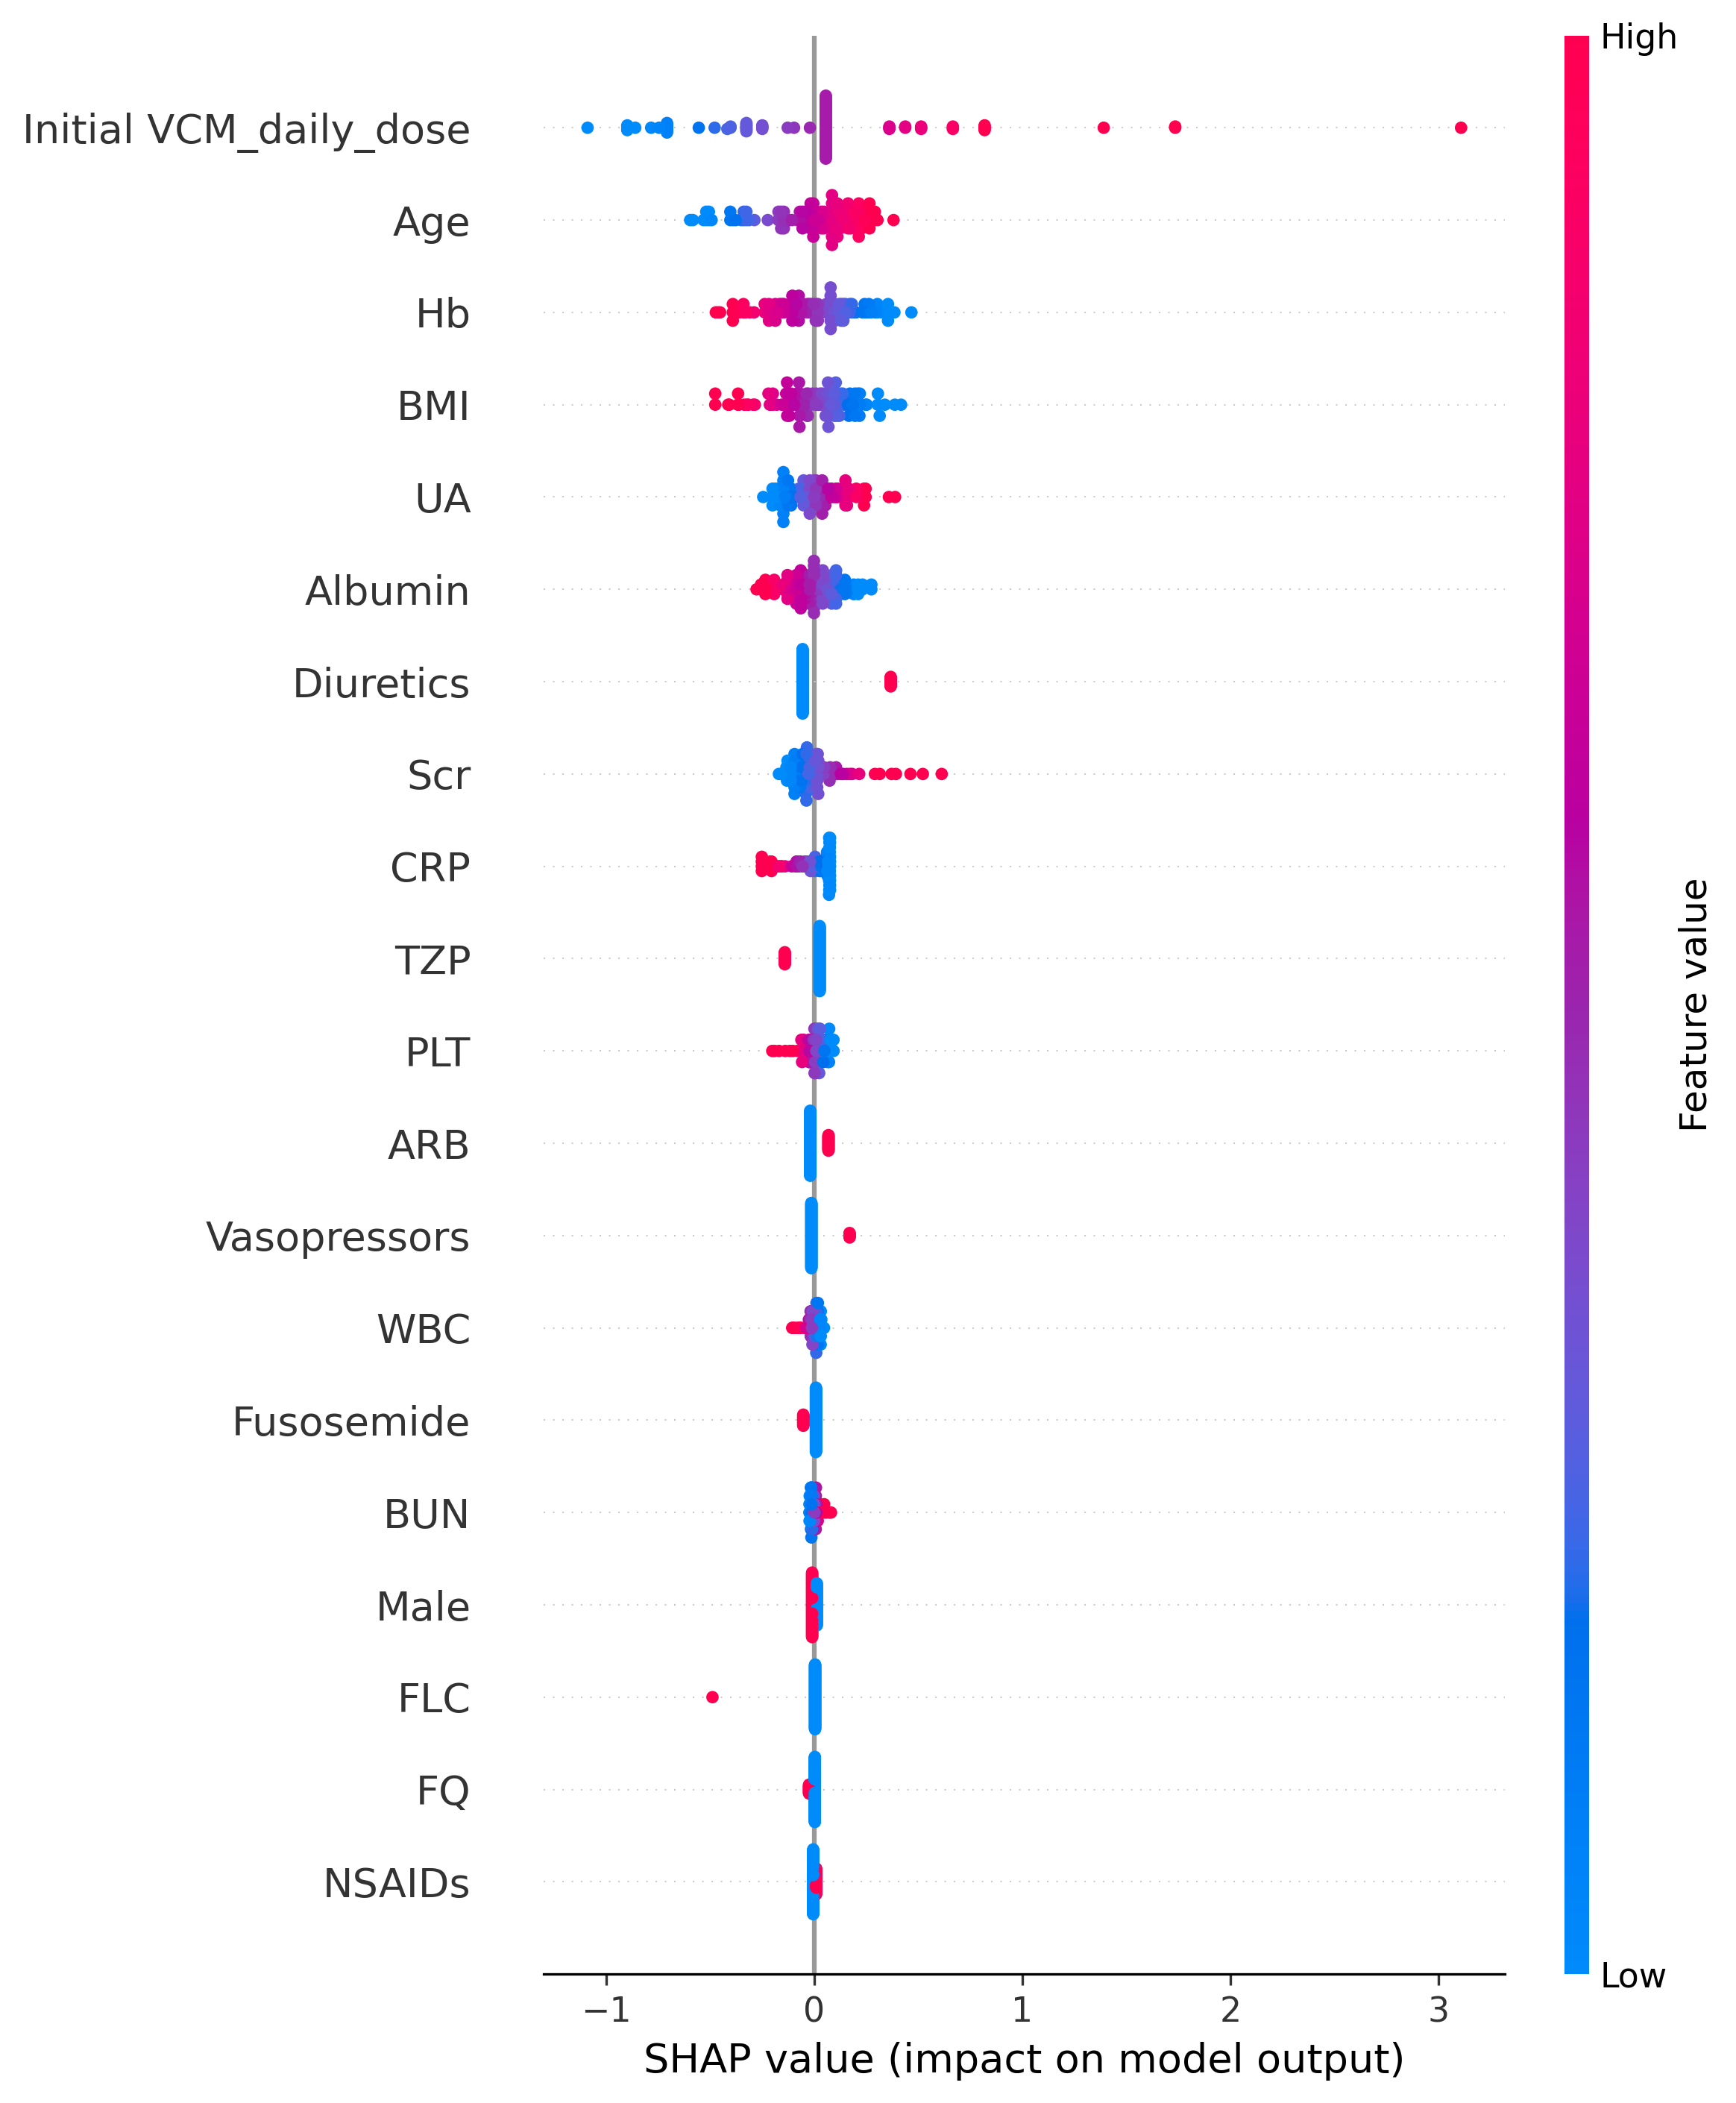

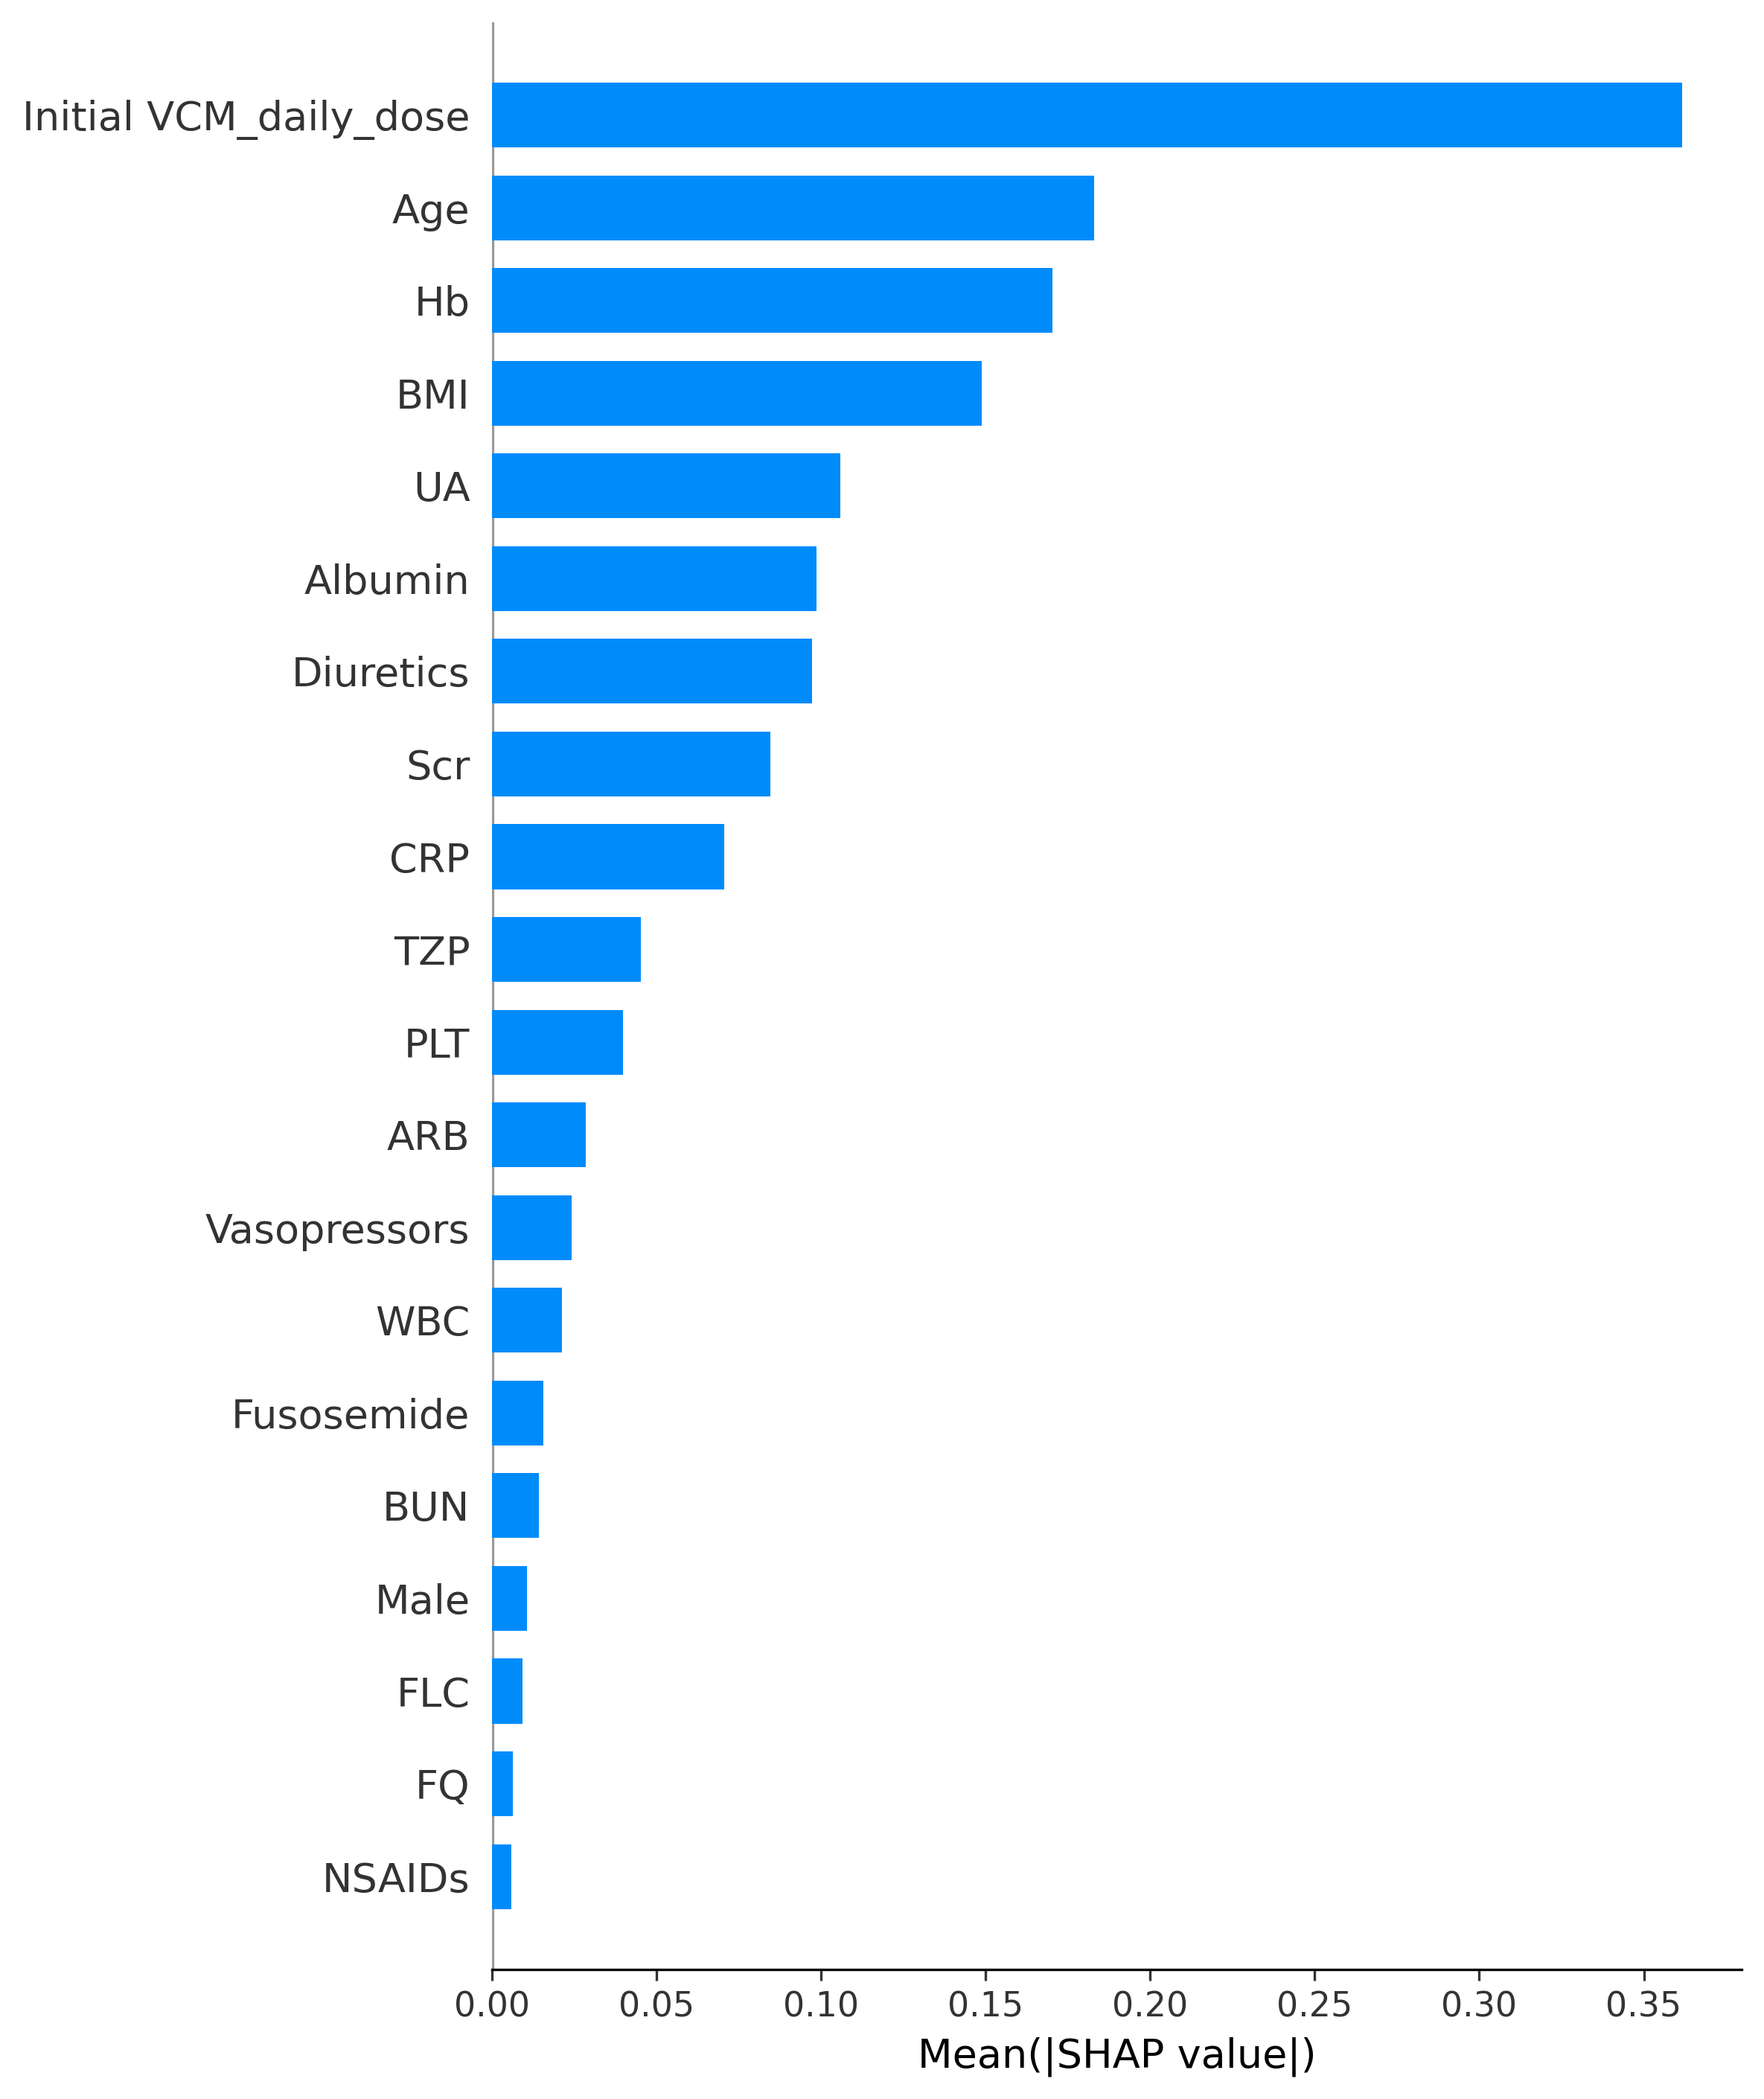

In [39]:
explainer = shap.LinearExplainer(ridge_model_no_smote, X_val, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_val)

plt.figure(figsize=(8, min(0.5*X_val.shape[1]+4, 20)), dpi=300)
shap.summary_plot(shap_values, X_val, plot_type='dot', show=False)
plt.tight_layout()
plt.savefig("figure4a_shap_summary_all.png", dpi=300)
plt.show()

plt.figure(figsize=(8, min(0.5*X_val.shape[1]+4, 20)), dpi=300)
shap.summary_plot(shap_values, X_val, plot_type='bar', show=False)
plt.gca().set_xlabel("Mean(|SHAP value|)")
plt.tight_layout()
plt.savefig("figure4b_shap_bar_all.png", dpi=300)
plt.show()

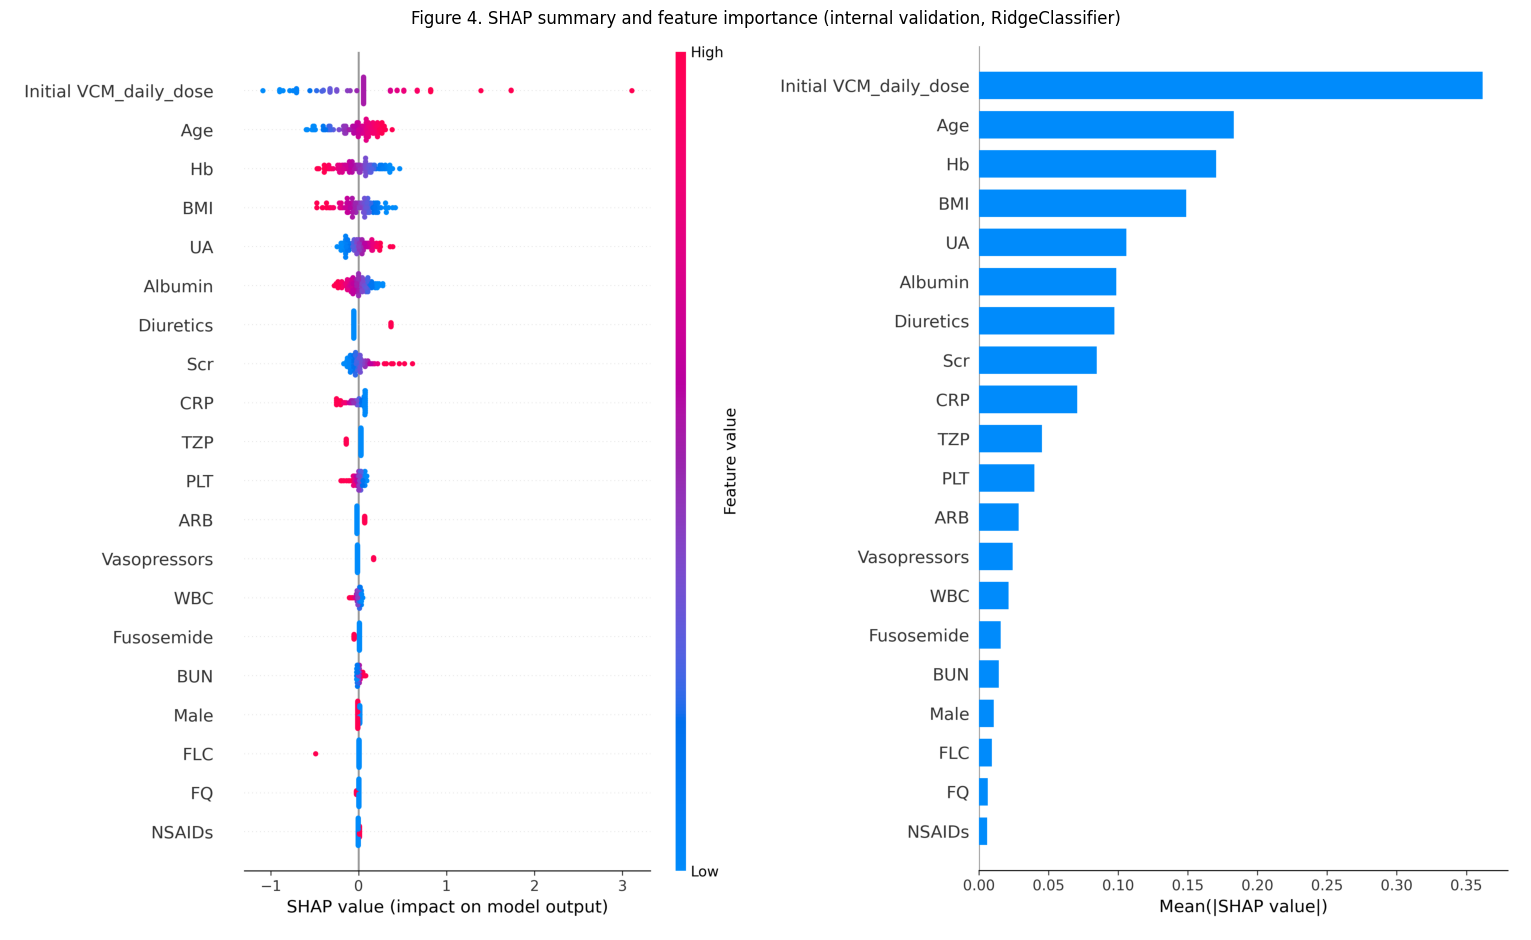

In [40]:
from PIL import Image

img_summary = Image.open('/content/figure4a_shap_summary_all.png')
img_bar = Image.open('/content/figure4b_shap_bar_all.png')

new_height = max(img_summary.height, img_bar.height)
new_width = img_summary.width + img_bar.width

combined = Image.new('RGB', (new_width, new_height), (255, 255, 255))
combined.paste(img_summary, (0, 0))
combined.paste(img_bar, (img_summary.width, 0))

combined.save('figure4_shap_combined.png')
combined.save('figure4_shap_combined.pdf')

plt.figure(figsize=(new_width/300, new_height/300))
plt.imshow(combined)
plt.axis('off')
plt.title('Figure 4. SHAP summary and feature importance (internal validation, RidgeClassifier)')
plt.tight_layout()
plt.show()

In [41]:
files.download('figure4_shap_combined.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
files.download("figure4a_shap_summary_all.png")
files.download("figure4b_shap_bar_all.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 14. Conclusions

1. **Internal Validation Performance:**
- RidgeClassifier (without SMOTE) achieved the highest sensitivity (83.3%) with ROC AUC 0.8375
- LogisticRegression with SMOTE showed balanced performance (66.7% sensitivity, improved precision)
- SMOTE application enhanced model balance but slightly reduced peak sensitivity
- Regression models showed limited predictive value (R² ~0.28) compared to binary classification
-------------------------

2. **Comparison with PrecisePK:**
- Our ML models outperformed PrecisePK software in sensitivity and precision
- PrecisePK: 66.7% sensitivity, 28.6% precision
- RidgeClassifier: 83.3% sensitivity, 37.5% precision
- LogisticRegression (SMOTE): 66.7% sensitivity, 38.7% precision

--------------------------
3. **External Validation:**
- Performance decreased on external dataset (expected with n=35)
- RidgeClassifier maintained exceptional sensitivity (85.7%)
- LogisticRegression showed more balanced external performance (71.4% sensitivity, 33.3% precision)
- Sensitivity preservation critical for clinical safety
-----------------------------
4. **Clinical Implications:**
- High sensitivity crucial for identifying patients at risk of vancomycin overexposure (AUC >600)
- RidgeClassifier recommended for high-sensitivity screening of overexposure risk
- Models can assist in vancomycin dosing decisions and complement existing TDM protocols
- Early identification enables proactive dose adjustments before toxic levels occur

-----------------------------

5. **Study Limitations & Future Directions:**
- Limited external validation cohort requires larger prospective studies
- Single-center training data may limit generalizability
- Prospective multicenter validation with diverse patient populations recommended
- Real-time clinical integration studies needed to assess workflow impact